In [2]:
import sys
sys.path.append('../_amigocloud')
import simplekml
from amigocloud import AmigoCloud
import pandas as pd
from shapely import wkb
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint
import os

In [3]:
def get_unidad_local():
    try:
        # ruta del archivo que contiene la información necesaria
        with open('../../unidad_local.txt', 'r') as file:
            unidad = file.readline().strip()
            return unidad
    except FileNotFoundError:
        print("El archivo 'unidad_local.txt' no se encuentra en la ruta especificada.")
    return None

def get_ruta_local():
    try:
        with open('../ruta_local.txt', 'r') as file:
            ruta = file.readline().strip()
            return ruta
    except FileNotFoundError:
        print("El archivo 'ruta_local.txt' no se encuentra en la ruta especificada.")
    return None

In [4]:
ors = 13

In [5]:
# RUTA ONEDRIVE
unidad = get_unidad_local()
ruta = get_ruta_local()
ruta_completa = os.path.join(unidad, ruta)
ruta_completa

'G:\\OneDrive - Ingenio Azucarero Guabira S.A\\_DATOS_PYTHON'

In [6]:
# leer token
acceso = open(ruta_completa + '/_keys/api_amigocloud_gral.key','r')
api_token = acceso.readlines()[0]
acceso.close()
amigocloud = AmigoCloud(token=api_token)
amigocloud

# leer los dos shps de siembra y puntos de planificacion
path_cat = unidad + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\SHP\catastro_S09_MIERCOLES.shp'
path_puntos = unidad + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\SHP\PUNTOS_PLAN.shp'
path_plan = unidad + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\SHP\PLANIFICACION.shp'
path_xlsx_parte = unidad + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\parte_diario_pulverizacion.xlsx'

# ACTUALIZAR SHP PLANIFICACION

In [7]:
gdf_puntos = gpd.read_file(path_puntos)
gdf_cat = gpd.read_file(path_cat)

In [8]:
# filtrar la semana de interes
gdf_puntos_select = gdf_puntos[gdf_puntos['os'] == ors]
gdf_puntos_sem = gdf_puntos_select.copy()
#quita caracteres especiales
gdf_puntos_sem['unidad_04'] = gdf_puntos_sem['unidad_04'].str.replace(r'[\r\n\t]', '', regex=True)
gdf_puntos_sem

,unidad_03,unidad_04,os,obs,procesado,geometry
11,1530,C.I.T.T.C.A.,13,None,None,"MULTIPOINT (487114.240 8094228.617, 487426.449..."
20,12478,SERRATE COLAMARINO HUGO,13,None,None,"MULTIPOINT (477358.339 8096845.054, 477439.038..."
21,1672,CAMPBELL BALCAZAR ALAN,13,None,None,"MULTIPOINT (500559.388 8098808.771, 501078.336..."
22,11576,ROJAS CALVI DAVID,13,None,None,MULTIPOINT (497767.259 8095006.066)
23,12075,ROJAS GONZALES TOMAS,13,None,None,"MULTIPOINT (499705.633 8091816.938, 499751.894..."
24,2816,DONOSO BLANCO ALBERTO,13,None,None,"MULTIPOINT (481911.866 8079467.429, 481963.724..."


In [9]:
multipoint_gdf = gdf_puntos_sem.copy()

In [10]:
# Crear una lista para almacenar los nuevos registros de puntos individuales
point_records = []
# Iterar sobre cada registro en el GeoDataFrame original
for idx, row in multipoint_gdf.iterrows():
    multipoint_geom = row.geometry
    # Verificar si la geometría es de tipo multipunto
    if isinstance(multipoint_geom, MultiPoint):
        for point in multipoint_geom.geoms:
            # Crear un nuevo registro para cada punto individual
            new_record = row.copy()
            new_record.geometry = point
            point_records.append(new_record)
    else:
        # Si la geometría ya es un punto, simplemente añadir el registro original
        point_records.append(row)

# Crear un nuevo GeoDataFrame con los registros de puntos individuales
puntos_indi = gpd.GeoDataFrame(point_records, crs=multipoint_gdf.crs)

In [11]:
# puntos individuales
puntos_indi

,unidad_03,unidad_04,os,obs,procesado,geometry
11,1530,C.I.T.T.C.A.,13,None,None,POINT (487114.240 8094228.617)
11,1530,C.I.T.T.C.A.,13,None,None,POINT (487426.449 8094048.700)
11,1530,C.I.T.T.C.A.,13,None,None,POINT (487786.283 8094392.659)
11,1530,C.I.T.T.C.A.,13,None,None,POINT (487812.742 8094905.951)
11,1530,C.I.T.T.C.A.,13,None,None,POINT (487929.158 8093784.116)
20,12478,SERRATE COLAMARINO HUGO,13,None,None,POINT (477358.339 8096845.054)
20,12478,SERRATE COLAMARINO HUGO,13,None,None,POINT (477439.038 8096845.054)
20,12478,SERRATE COLAMARINO HUGO,13,None,None,POINT (477518.413 8096823.888)
20,12478,SERRATE COLAMARINO HUGO,13,None,None,POINT (477528.996 8097780.358)
20,12478,SERRATE COLAMARINO HUGO,13,None,None,POINT (477535.611 8097536.941)


<Axes: >

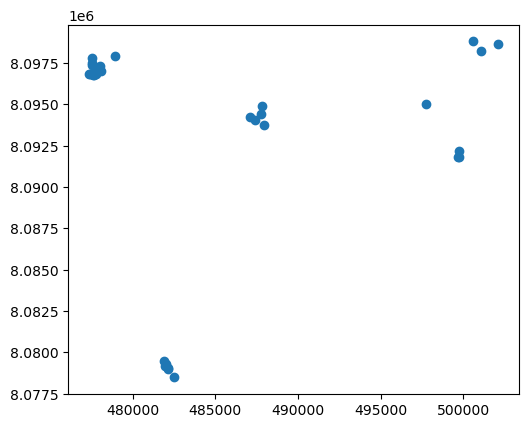

In [12]:
puntos_indi.plot()

In [13]:
# identifoca los lotes que se intersectan
gdf_lotes_cat = gpd.sjoin(gdf_cat, puntos_indi, how='inner', predicate='intersects')
# filtra los lotes intersectados en la capa original
poligonos_intersect_cat = gdf_cat.loc[gdf_cat.index.isin(gdf_lotes_cat.index)]
# copy
poligonos_intersect_cat = poligonos_intersect_cat.copy()
poligonos_intersect_cat = poligonos_intersect_cat[['unidad_01', 'unidad_02', 'unidad_03', 'unidad_04', 'unidad_05', 'area', 'soca', 'zona', 'geometry']]

In [14]:
# Cambiar el nombre de la columna 'old_name' a 'new_name'
poligonos_intersect_cat.rename(columns={'zona': 'inst'}, inplace=True)

In [15]:
poligonos_intersect_cat

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry
5129,1454.0,MIRAFLORES Y FAMOSA--CAMPBELL FERNANDO,41534.0,CAMPBELL MEDINA FERNANDO WALTER,F7.1,21.216284,0.0,50,"POLYGON ((502537.775 8098763.195, 502475.870 8..."
5173,74.0,LOS ARROYOS--DONOSO,2816.0,DONOSO BLANCO ALBERTO,A4.1,2.120823,0.0,69,"POLYGON ((482289.170 8078979.600, 482313.775 8..."
6333,1702.0,RANCHO DON JULIO--ROJAS TOMAS,11576.0,ROJAS CALVI DAVID,L3,9.198121,2.0,50,"POLYGON ((499883.045 8091911.802, 499875.704 8..."
7557,577.0,SAN ANTONIO--IAG,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,L3,14.046489,0.0,50,"POLYGON ((487193.395 8094028.850, 487262.759 8..."
7558,577.0,SAN ANTONIO--IAG,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,L4,16.907230,0.0,50,"POLYGON ((487326.883 8094631.099, 487256.226 8..."
7560,577.0,SAN ANTONIO--IAG,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,L2,8.892186,0.0,50,"POLYGON ((487794.936 8093976.325, 487947.338 8..."
7561,314.0,LA FORTALEZA I--ROJAS CALVI,12075.0,ROJAS GONZALES TOMAS,L2,22.646277,0.0,50,"POLYGON ((497409.069 8095059.786, 498083.500 8..."
7562,577.0,SAN ANTONIO--IAG,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,L1,48.404143,0.0,50,"POLYGON ((487345.806 8094635.527, 488024.724 8..."
7564,577.0,SAN ANTONIO--IAG,41594.0,AGROPECUARIA CAMPO DULCE S.R.L.,L5,12.004987,0.0,50,"POLYGON ((488023.791 8094765.791, 487704.816 8..."
8551,1702.0,RANCHO DON JULIO--ROJAS TOMAS,12075.0,ROJAS GONZALES TOMAS,L2,21.349849,3.0,50,"POLYGON ((499934.332 8092504.861, 499877.822 8..."


In [16]:
# CAMBIAR NOMBRE DATOS DE UNIDAD_03 Y UNDIAD_04 DE LOTES SOLICITADOS A LO INDICADO EN LOS PUNTOS
# Iterar sobre cada punto y encontrar el polígono que intersecta
for idx, point in puntos_indi.iterrows():
    point_geom = point.geometry
    matching_polygons = poligonos_intersect_cat[poligonos_intersect_cat.intersects(point_geom)]
    
    # Actualizar los campos de los polígonos que intersectan con los valores del punto
    for poly_idx in matching_polygons.index:
        poligonos_intersect_cat.at[poly_idx, 'unidad_03'] = point['unidad_03']
        poligonos_intersect_cat.at[poly_idx, 'unidad_04'] = point['unidad_04']

In [17]:
poligonos_intersect_cat.head(3)

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry
5129,1454.0,MIRAFLORES Y FAMOSA--CAMPBELL FERNANDO,1672.0,CAMPBELL BALCAZAR ALAN,F7.1,21.216284,0.0,50,"POLYGON ((502537.775 8098763.195, 502475.870 8..."
5173,74.0,LOS ARROYOS--DONOSO,2816.0,DONOSO BLANCO ALBERTO,A4.1,2.120823,0.0,69,"POLYGON ((482289.170 8078979.600, 482313.775 8..."
6333,1702.0,RANCHO DON JULIO--ROJAS TOMAS,12075.0,ROJAS GONZALES TOMAS,L3,9.198121,2.0,50,"POLYGON ((499883.045 8091911.802, 499875.704 8..."


In [18]:
# agrega los campos faltantes
poligonos_intersect_cat['os'] = ors

In [19]:
plan = poligonos_intersect_cat.copy()

In [20]:
plan.head(3)

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry,os
5129,1454.0,MIRAFLORES Y FAMOSA--CAMPBELL FERNANDO,1672.0,CAMPBELL BALCAZAR ALAN,F7.1,21.216284,0.0,50,"POLYGON ((502537.775 8098763.195, 502475.870 8...",13
5173,74.0,LOS ARROYOS--DONOSO,2816.0,DONOSO BLANCO ALBERTO,A4.1,2.120823,0.0,69,"POLYGON ((482289.170 8078979.600, 482313.775 8...",13
6333,1702.0,RANCHO DON JULIO--ROJAS TOMAS,12075.0,ROJAS GONZALES TOMAS,L3,9.198121,2.0,50,"POLYGON ((499883.045 8091911.802, 499875.704 8...",13


<Axes: >

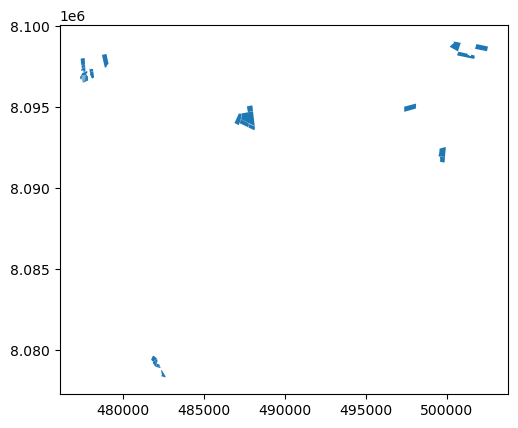

In [21]:
plan.plot()

In [22]:
plan['area'].sum()

314.76989711220216

In [23]:
#RECALCULAR EL AREA
plan['area'] = plan.geometry.area / 10000

In [24]:
plan['area'].sum()

316.42357821429346

In [25]:
# carga el shp de planificacion
gdf_plan = gpd.read_file(path_plan)

In [26]:
# determina el ultimo id
last_id = 0
if gdf_plan['id'].max() > 0:
    last_id = gdf_plan['id'].max()
else:
    last_id = 0

In [27]:
last_id

148

In [28]:
# Asignar valores incrementales a la columna 'id' empezando desde last_id + 1
plan['id'] = range(last_id + 1, last_id + 1 + len(plan))

In [29]:
plan.head(3)

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry,os,id
5129,1454.0,MIRAFLORES Y FAMOSA--CAMPBELL FERNANDO,1672.0,CAMPBELL BALCAZAR ALAN,F7.1,22.309061,0.0,50,"POLYGON ((502537.775 8098763.195, 502475.870 8...",13,149
5173,74.0,LOS ARROYOS--DONOSO,2816.0,DONOSO BLANCO ALBERTO,A4.1,2.120823,0.0,69,"POLYGON ((482289.170 8078979.600, 482313.775 8...",13,150
6333,1702.0,RANCHO DON JULIO--ROJAS TOMAS,12075.0,ROJAS GONZALES TOMAS,L3,9.435752,2.0,50,"POLYGON ((499883.045 8091911.802, 499875.704 8...",13,151


In [30]:
len(plan)

30

In [31]:
# union de los dos gdf
gdf_pla_gral = pd.concat([gdf_plan, plan], ignore_index=True)

In [32]:
gdf_pla_gral['area'].sum()

1704.055421139012

In [33]:
gdf_pla_gral['unidad_01'] = gdf_pla_gral['unidad_01'].astype(int)
gdf_pla_gral['unidad_03'] = gdf_pla_gral['unidad_03'].astype(int)
gdf_pla_gral['os'] = gdf_pla_gral['os'].astype(int)
gdf_pla_gral['soca'] = gdf_pla_gral['soca'].astype(int)
gdf_pla_gral['id'] = gdf_pla_gral['id'].astype(int)
gdf_pla_gral['inst'] = gdf_pla_gral['inst'].astype(int)

In [34]:
gdf_pla_gral

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,os,soca,id,inst,idd,geometry
0,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L31,30.260942,1,2,1,50,1.0,"POLYGON ((504085.659 8094406.031, 503737.808 8..."
1,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L16,23.216246,1,4,2,50,1.0,"POLYGON ((504352.053 8094797.970, 504272.088 8..."
2,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,ER-L6,19.683505,1,5,3,50,1.0,"POLYGON ((503260.583 8094596.306, 503714.735 8..."
3,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L35,7.795719,1,4,4,50,1.0,"POLYGON ((504693.348 8094607.629, 504673.327 8..."
4,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L34,7.048921,1,5,5,50,1.0,"POLYGON ((504137.327 8094415.183, 504648.080 8..."
...,...,...,...,...,...,...,...,...,...,...,...,...
160,74,LOS ARROYOS--DONOSO,2816,DONOSO BLANCO ALBERTO,A12,5.821546,13,5,174,69,NaN,"POLYGON ((482403.769 8078490.606, 482402.999 8..."
161,74,LOS ARROYOS--DONOSO,2816,DONOSO BLANCO ALBERTO,A1.2,4.926595,13,4,175,69,NaN,"POLYGON ((481996.042 8078993.326, 481927.495 8..."
162,74,LOS ARROYOS--DONOSO,2816,DONOSO BLANCO ALBERTO,A1.4,7.446862,13,4,176,69,NaN,"POLYGON ((481911.684 8079638.831, 482040.570 8..."
163,74,LOS ARROYOS--DONOSO,2816,DONOSO BLANCO ALBERTO,A3,2.445677,13,7,177,69,NaN,"POLYGON ((482081.921 8079193.997, 481942.009 8..."


In [35]:
# exportar los datos en nuevo shp
gdf_pla_gral.to_file(path_plan)

# CARGAR PLANIFICACION A AMIGOCLOUD

In [36]:
def convertir_a_multipolygon(geometry):
    if isinstance(geometry, Polygon):
        return MultiPolygon([geometry])
    return geometry

def convertir_a_wkb(polygon):
    wkb_data = wkb.dumps(polygon, hex=True)
    return wkb_data

In [37]:
# repreyectar a WGS84
gdf_pla_gral = plan.to_crs(epsg=4326)
# convertir poligonos a multipoligonos
gdf_pla_gral['geometry'] = gdf_pla_gral['geometry'].apply(convertir_a_multipolygon)

In [38]:
gdf_pla_gral['unidad_01'] = gdf_pla_gral['unidad_01'].astype(int)
gdf_pla_gral['unidad_03'] = gdf_pla_gral['unidad_03'].astype(int)
gdf_pla_gral['os'] = gdf_pla_gral['os'].astype(int)
gdf_pla_gral['soca'] = gdf_pla_gral['soca'].astype(int)
gdf_pla_gral['id'] = gdf_pla_gral['id'].astype(int)
gdf_pla_gral['inst'] = gdf_pla_gral['inst'].astype(int)

In [ ]:
len(gdf_pla_gral)

In [ ]:
# recorrer el gdf de lotes y cargarlo a amigocloud
id_proyecto = f'https://app.amigocloud.com/api/v1/projects/35248/sql'
for index, row in gdf_pla_gral.iterrows():
    wkb_hex = convertir_a_wkb(row['geometry'])
    insert_sql = f"""
    INSERT INTO dataset_360912 (id, unidad_01, unidad_02, unidad_03, unidad_04, unidad_05, area, os, geometry)
    VALUES ({row['id']}, {row['unidad_01']}, '{row['unidad_02']}', {row['unidad_03']}, '{row['unidad_04']}', '{row['unidad_05']}', {row['area']}, '{row['os']}', ST_SetSRID(ST_GeomFromWKB('\\x{wkb_hex}'), 4326));
    """
    query_sql = {'query': insert_sql}
    resultado_post = amigocloud.post(id_proyecto, query_sql)

# CARGAR XLSX

In [40]:
from openpyxl import load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from datetime import datetime

In [41]:
# Cargar el archivo Excel
sheet_name = 'DATA'
table_name = 'tbl_data'

In [42]:
excel_data = pd.read_excel(path_xlsx_parte)

In [43]:
gdf_pla_gral

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry,os,id
5816,114,SAUSALITO--ROCA,11860,ROCA SERRANO ARMANDO,L3,31.705938,1,50,"MULTIPOLYGON (((-63.37545 -17.22734, -63.37205...",12,145
9668,114,SAUSALITO--ROCA,11860,ROCA SERRANO ARMANDO,L5.12,34.727892,0,50,"MULTIPOLYGON (((-63.37167 -17.22570, -63.37207...",12,146
9793,114,SAUSALITO--ROCA,11860,ROCA SERRANO ARMANDO,L5.9,24.477216,0,50,"MULTIPOLYGON (((-63.36705 -17.22193, -63.36755...",12,147
9955,114,SAUSALITO--ROCA,11860,ROCA SERRANO ARMANDO,L5.14,14.046284,0,50,"MULTIPOLYGON (((-63.36694 -17.22210, -63.36527...",12,148


In [44]:
new_data = {
    'INSTITUCION':list(gdf_pla_gral['inst']), 
    'COD CANERO': list(gdf_pla_gral['unidad_03']),
    'NOMBRE CANERO': list(gdf_pla_gral['unidad_04']),
    'COD PROPIEDAD': list(gdf_pla_gral['unidad_01']),
    'NOMBRE PROPIEDAD': list(gdf_pla_gral['unidad_02']),
    'LOTE': list(gdf_pla_gral['unidad_05']),
    'HECTAREA': list(gdf_pla_gral['area']),
    'CICLO': list(gdf_pla_gral['soca']),
    'ID': list(gdf_pla_gral['id']),
    'OS': list(gdf_pla_gral['os'])
}

new_df = pd.DataFrame(new_data)

In [45]:
new_df.head(3)

,INSTITUCION,COD CANERO,NOMBRE CANERO,COD PROPIEDAD,NOMBRE PROPIEDAD,LOTE,HECTAREA,CICLO,ID,OS
0,50,11860,ROCA SERRANO ARMANDO,114,SAUSALITO--ROCA,L3,31.705938,1,145,12
1,50,11860,ROCA SERRANO ARMANDO,114,SAUSALITO--ROCA,L5.12,34.727892,0,146,12
2,50,11860,ROCA SERRANO ARMANDO,114,SAUSALITO--ROCA,L5.9,24.477216,0,147,12


In [46]:
# extrae los valores de Nº DE LABOR, convierte a conjunto y luego a lista
lista_cite = list(set(excel_data['Nº DE LABOR']))

In [47]:
# extrae los valores numericos de cada Nº DE LABOR
lista_num = [int(i.split('-')[-1]) for i in lista_cite]
lista_num

[10,
 1,
 24,
 18,
 25,
 15,
 14,
 8,
 6,
 13,
 11,
 9,
 4,
 12,
 22,
 19,
 23,
 17,
 21,
 20,
 5,
 2]

In [48]:
next_num_labor = max(lista_num) + 1
next_num_labor

26

In [49]:
new_df['MEZCLA'] = 0
new_df['LABOR_REALIZADA'] = 'PUL. CON DRONE'
new_df['Nº DE LABOR'] = 'PA-2025-' + str(next_num_labor)

In [50]:
new_df

,INSTITUCION,COD CANERO,NOMBRE CANERO,COD PROPIEDAD,NOMBRE PROPIEDAD,LOTE,HECTAREA,CICLO,ID,OS,MEZCLA,LABOR_REALIZADA,Nº DE LABOR
0,50,11860,ROCA SERRANO ARMANDO,114,SAUSALITO--ROCA,L3,31.705938,1,145,12,0,PUL. CON DRONE,PA-2025-26
1,50,11860,ROCA SERRANO ARMANDO,114,SAUSALITO--ROCA,L5.12,34.727892,0,146,12,0,PUL. CON DRONE,PA-2025-26
2,50,11860,ROCA SERRANO ARMANDO,114,SAUSALITO--ROCA,L5.9,24.477216,0,147,12,0,PUL. CON DRONE,PA-2025-26
3,50,11860,ROCA SERRANO ARMANDO,114,SAUSALITO--ROCA,L5.14,14.046284,0,148,12,0,PUL. CON DRONE,PA-2025-26


In [51]:
final_data = pd.concat([excel_data, new_df], ignore_index=True)

In [52]:
final_data.to_excel(path_xlsx_parte, index=False)